In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import utilities
import os
import sys
os.chdir("/Volumes/kueck/PublicDataAnalysis/CASCAM_style_subtype_classification/src/preprocessing")
# os.getcwd() not working as expected, so need to set wd manually (update as needed).
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(parent_dir)

from utilities import Subtype, convert_subtype_to_int, convert_int_to_subtype, evaluate_predictions

In [2]:
batch_corrected_counts_path = (
    "../../data/batch_corrected_data/pycombat_batch_corrected_counts.tsv"
)

combined_metadata_path = "../../data/formatted_rnaseq_data/metadata.tsv"

selected_genes_path = "../../data/differential_analysis/pycombat_batch_corrected_dex_selected_genes.tsv"

## Load data

In [17]:
corrected_expression = pd.read_csv(batch_corrected_counts_path, sep="\t", index_col=0)
# TODO: test whether log2 transformation helps
log2_corrected_expression = np.log2(corrected_expression + 1)
log2_corrected_expression = log2_corrected_expression.T
log2_corrected_expression.rename_axis("sample_id", inplace=True)
display(log2_corrected_expression.head())

metadata = pd.read_csv(combined_metadata_path, sep="\t", index_col=0)
display(metadata.head())

selected_genes = pd.read_csv(selected_genes_path, sep="\t", index_col=0)

# Subset features to be only the selected genes
features = log2_corrected_expression[list(set(log2_corrected_expression.columns).intersection(selected_genes.index.tolist()))]
display(features.head())

Gene,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZSWIM8-AS1,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
sample_id,,,,,,,,,,,,,,,,,,,,,
GSE189553_0_CCC,4.087463,7.383704,12.213712,6.000000,6.000000,2.584963,2.321928,9.915879,2.0,11.171177,...,3.169925,10.393390,9.588715,7.599913,9.047124,10.088788,7.826548,10.880349,11.933322,10.697836
GSE189553_1_CCC,5.882643,7.839204,12.158925,6.169925,6.000000,3.169925,2.321928,10.581201,2.0,11.206404,...,4.169925,10.270295,9.071462,7.813781,8.939579,10.154818,7.820179,11.173677,11.954923,10.361944
GSE189553_2_CCC,5.832890,7.546894,12.210367,6.409391,6.000000,2.584963,2.321928,9.588715,2.0,10.975848,...,4.459432,10.096715,8.930737,7.727920,8.994353,9.978710,6.426265,10.818582,11.769425,10.617467
GSE189553_3_CCC,4.392317,6.832890,12.492604,6.357552,5.832890,2.584963,2.321928,10.653741,2.0,11.154185,...,3.000000,10.484823,9.659996,6.339850,8.930737,9.893302,7.066089,11.064069,11.975490,10.125413
GSE189553_4_CCC,5.643856,7.857981,11.857592,5.781360,6.392317,2.584963,3.169925,9.810572,2.0,10.941781,...,1.584963,10.183635,9.366322,7.636625,9.014020,10.020980,8.596190,10.969387,12.026869,10.579316


,dataset_name,original_sample_name,type
sample_id,,,
GSE189553_0_CCC,GSE189553,CCC_1,CCC
GSE189553_1_CCC,GSE189553,CCC_2,CCC
GSE189553_2_CCC,GSE189553,CCC_3,CCC
GSE189553_3_CCC,GSE189553,CCC_4,CCC
GSE189553_4_CCC,GSE189553,CCC_5,CCC


Gene,MYOD1,BICD1,CHRDL1,RNU6-39P,SLC12A1,GPR61,ASCL1,ANKRD34B,C1RL,CDH17,...,MYH6,CASR,IL1RL2,MAGEA11,GDPD5,PAGE2B,MORN5,PTPRT,PHF12,AGBL1-AS1
sample_id,,,,,,,,,,,,,,,,,,,,,
GSE189553_0_CCC,2.0,12.108851,5.426265,2.0,3.000000,3.321928,1.0,7.409391,10.696098,3.321928,...,2.000000,4.000000,6.768184,2.321928,8.873444,1.000000,4.321928,3.321928,11.220983,0.0
GSE189553_1_CCC,2.0,12.461224,5.426265,1.0,6.022368,3.906891,1.0,5.392317,11.181773,6.768184,...,2.000000,4.000000,7.108524,2.321928,7.977280,1.000000,7.139551,3.321928,11.508290,0.0
GSE189553_2_CCC,2.0,11.628446,5.426265,1.0,4.906891,3.321928,1.0,6.066089,10.986553,2.807355,...,2.000000,5.247928,7.000000,2.321928,8.511753,2.000000,7.330917,7.599913,11.267372,0.0
GSE189553_3_CCC,2.0,10.946906,5.426265,1.0,7.409391,3.906891,1.0,5.523562,11.159241,2.584963,...,2.000000,4.857981,6.000000,2.321928,8.344296,1.584963,2.000000,10.178665,11.314017,0.0
GSE189553_4_CCC,2.0,11.687813,5.426265,1.0,7.800900,3.321928,1.0,6.339850,11.096715,3.321928,...,3.169925,8.930737,7.000000,3.321928,8.810572,1.000000,5.857981,2.321928,11.253257,0.0


## Train SVM

In [11]:
# Merge rnaseq data for selected genes with metadata
features_with_classification = pd.merge(
    features, metadata["type"], left_index=True, right_index=True
)
features_with_classification["type_int"] = features_with_classification["type"].apply(
    lambda x: convert_subtype_to_int(x))
features_with_classification.drop(columns=["type"], inplace=True)

# Split data into training and testing sets (don't need validation for SVM)
train_data, test_data = train_test_split(
    features_with_classification, test_size=0.25, stratify=features_with_classification["type_int"], random_state=42
)
train_labels = train_data["type_int"]
test_labels = test_data["type_int"]
train_data = train_data.drop(columns=["type_int"])
test_data = test_data.drop(columns=["type_int"])

# Train SVM
classifier = SVC(kernel="linear")
classifier.fit(train_data, train_labels)

SVC(kernel='linear')

Test SVM

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

,Precision,Recall,F1,Accuracy,Num_in_test_set
Overall (weighted),0.71142,0.791667,0.749183,0.791667,72.0
HGSC,1.00000,0.928571,0.962963,0.928571,56.0
LGSC,0.00000,0.000000,0.000000,0.000000,2.0
EC,0.00000,0.000000,0.000000,0.000000,3.0
CCC,1.00000,0.555556,0.714286,0.555556,9.0
MC,0.00000,0.000000,0.000000,0.000000,2.0


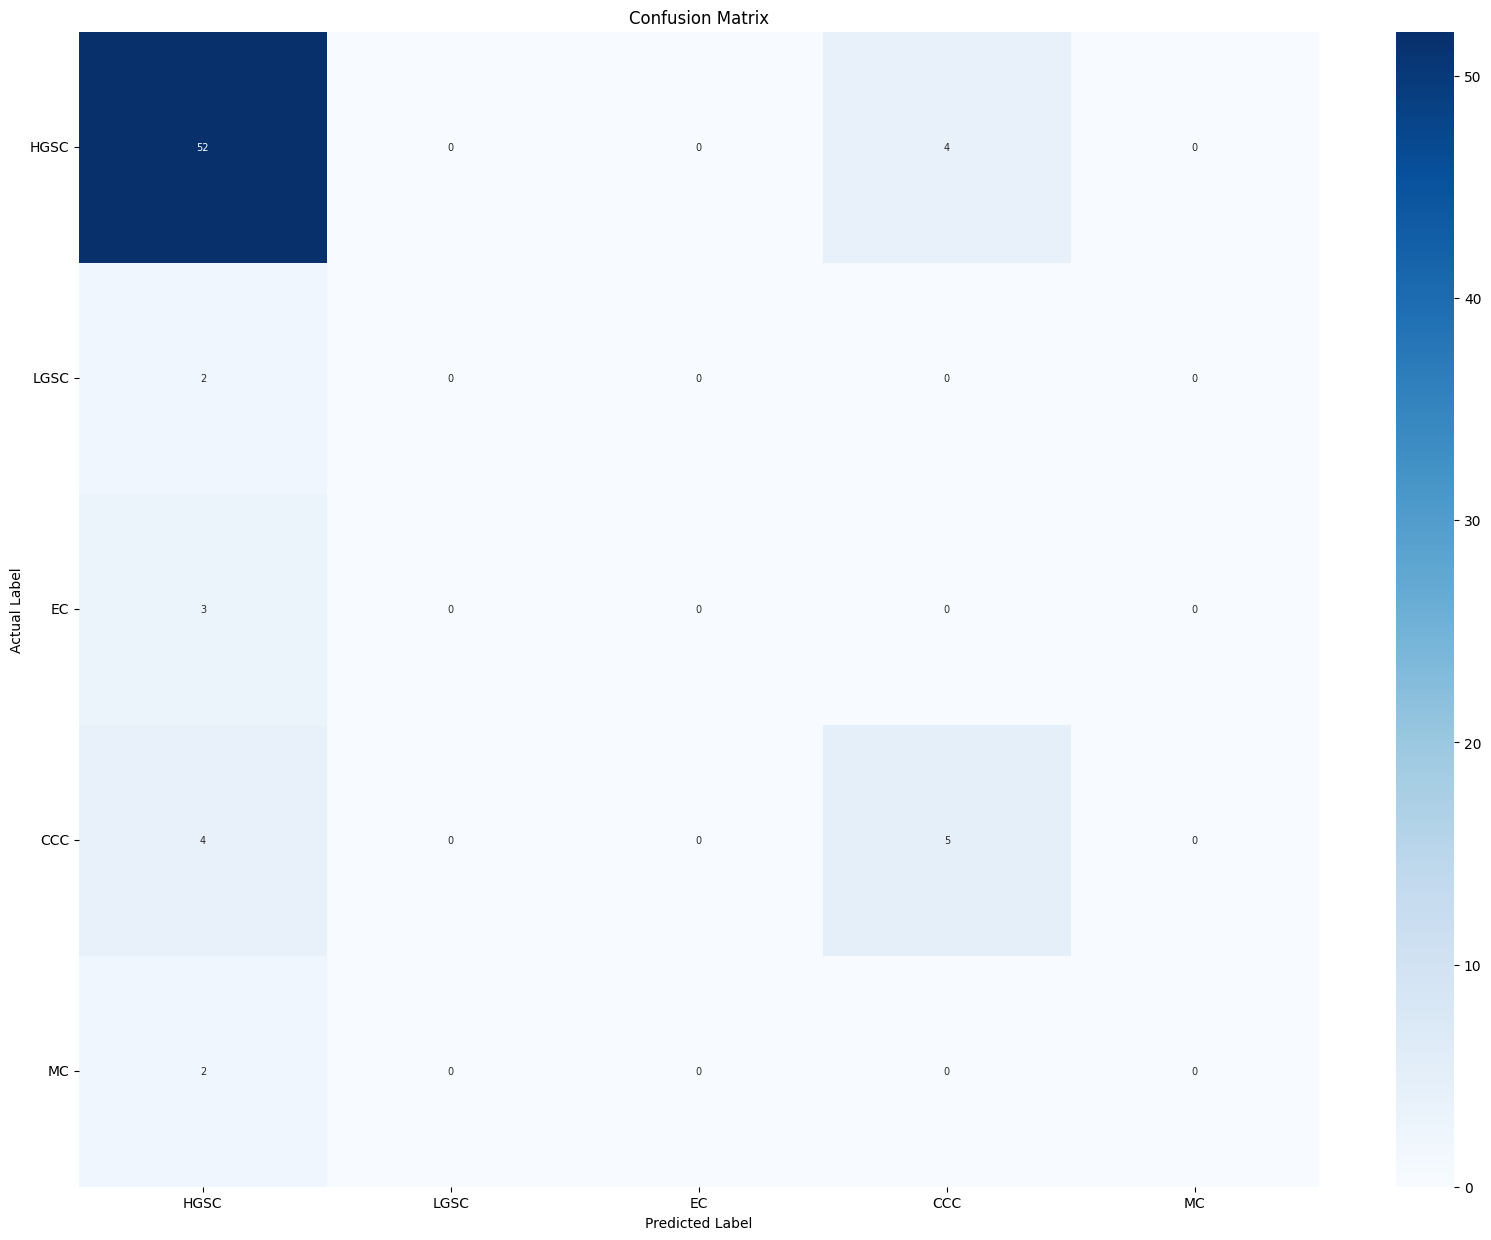

In [12]:
# Use trained SVM to classify test data
predicted_labels = classifier.predict(test_data)

# Convert to subtype strings so confusion matrix labels are meaningful
predicted_labels_strs = [convert_int_to_subtype(label).name for label in predicted_labels]
testing_labels_strs = [convert_int_to_subtype(label).name for label in test_labels]

possible_labels = list(Subtype.__members__.keys())
evaluate_predictions(testing_labels_strs, predicted_labels_strs, possible_labels)


## Downsample data and Train SVM

In [13]:
# Down sample so that there are the same numbers of each subtype
subtype_counts = metadata["type"].value_counts()
min_count = subtype_counts.min()
downsampled_metadata = pd.DataFrame()
for subtype in metadata["type"].unique():
    subtype_data = metadata[metadata["type"] == subtype]
    downsampled_metadata = pd.concat(
        [downsampled_metadata, subtype_data.sample(min_count, random_state=42)]
    )

display(downsampled_metadata)

downsampled_features = features.loc[
    downsampled_metadata.index
]

,dataset_name,original_sample_name,type
sample_id,,,
GSE121103_4_CCC,GSE121103,KL05-NEBindex5_S5_R1_001,CCC
GSE160692_2_CCC,GSE160692,OVA3,CCC
GSE121103_2_CCC,GSE121103,KL03-NEBindex3_S3_R1_001,CCC
GSE160692_10_CCC,GSE160692,OVA11,CCC
GSE160692_4_CCC,GSE160692,OVA5,CCC
GSE101108_5_CCC,GSE101108,OV188,CCC
GSE160692_8_CCC,GSE160692,OVA9,CCC
TCGA_102_HGSC,TCGA,TCGA-61-2104,HGSC
TCGA_118_HGSC,TCGA,TCGA-24-1551,HGSC


Train SVM

In [14]:
# Merge rnaseq data with metadata
downsampled_features_with_classification = pd.merge(
    downsampled_features, downsampled_metadata["type"], left_index=True, right_index=True
)
downsampled_features_with_classification["type_int"] = downsampled_features_with_classification["type"].apply(
    lambda x: convert_subtype_to_int(x))
downsampled_features_with_classification.drop(columns=["type"], inplace=True)

# Split data into training and testing sets (don't need validation for SVM)
downsampled_train_data, downsampled_test_data = train_test_split(
    downsampled_features_with_classification, test_size=0.25, stratify=downsampled_features_with_classification["type_int"], random_state=42
)
downsampled_train_labels = downsampled_train_data["type_int"]
downsampled_test_labels = downsampled_test_data["type_int"]
downsampled_train_data = downsampled_train_data.drop(columns=["type_int"])
downsampled_test_data = downsampled_test_data.drop(columns=["type_int"])

# Train SVM
downsampled_classifier = SVC(kernel="linear")
downsampled_classifier.fit(downsampled_train_data, downsampled_train_labels)

SVC(kernel='linear')

Test SVM

/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

,Precision,Recall,F1,Accuracy,Num_in_test_set
Overall (weighted),0.259259,0.444444,0.314815,0.444444,9.0
HGSC,0.000000,0.000000,0.000000,0.000000,2.0
LGSC,1.000000,1.000000,1.000000,1.000000,1.0
EC,1.000000,1.000000,1.000000,1.000000,2.0
CCC,0.000000,0.000000,0.000000,0.000000,2.0
MC,1.000000,0.500000,0.666667,0.500000,2.0


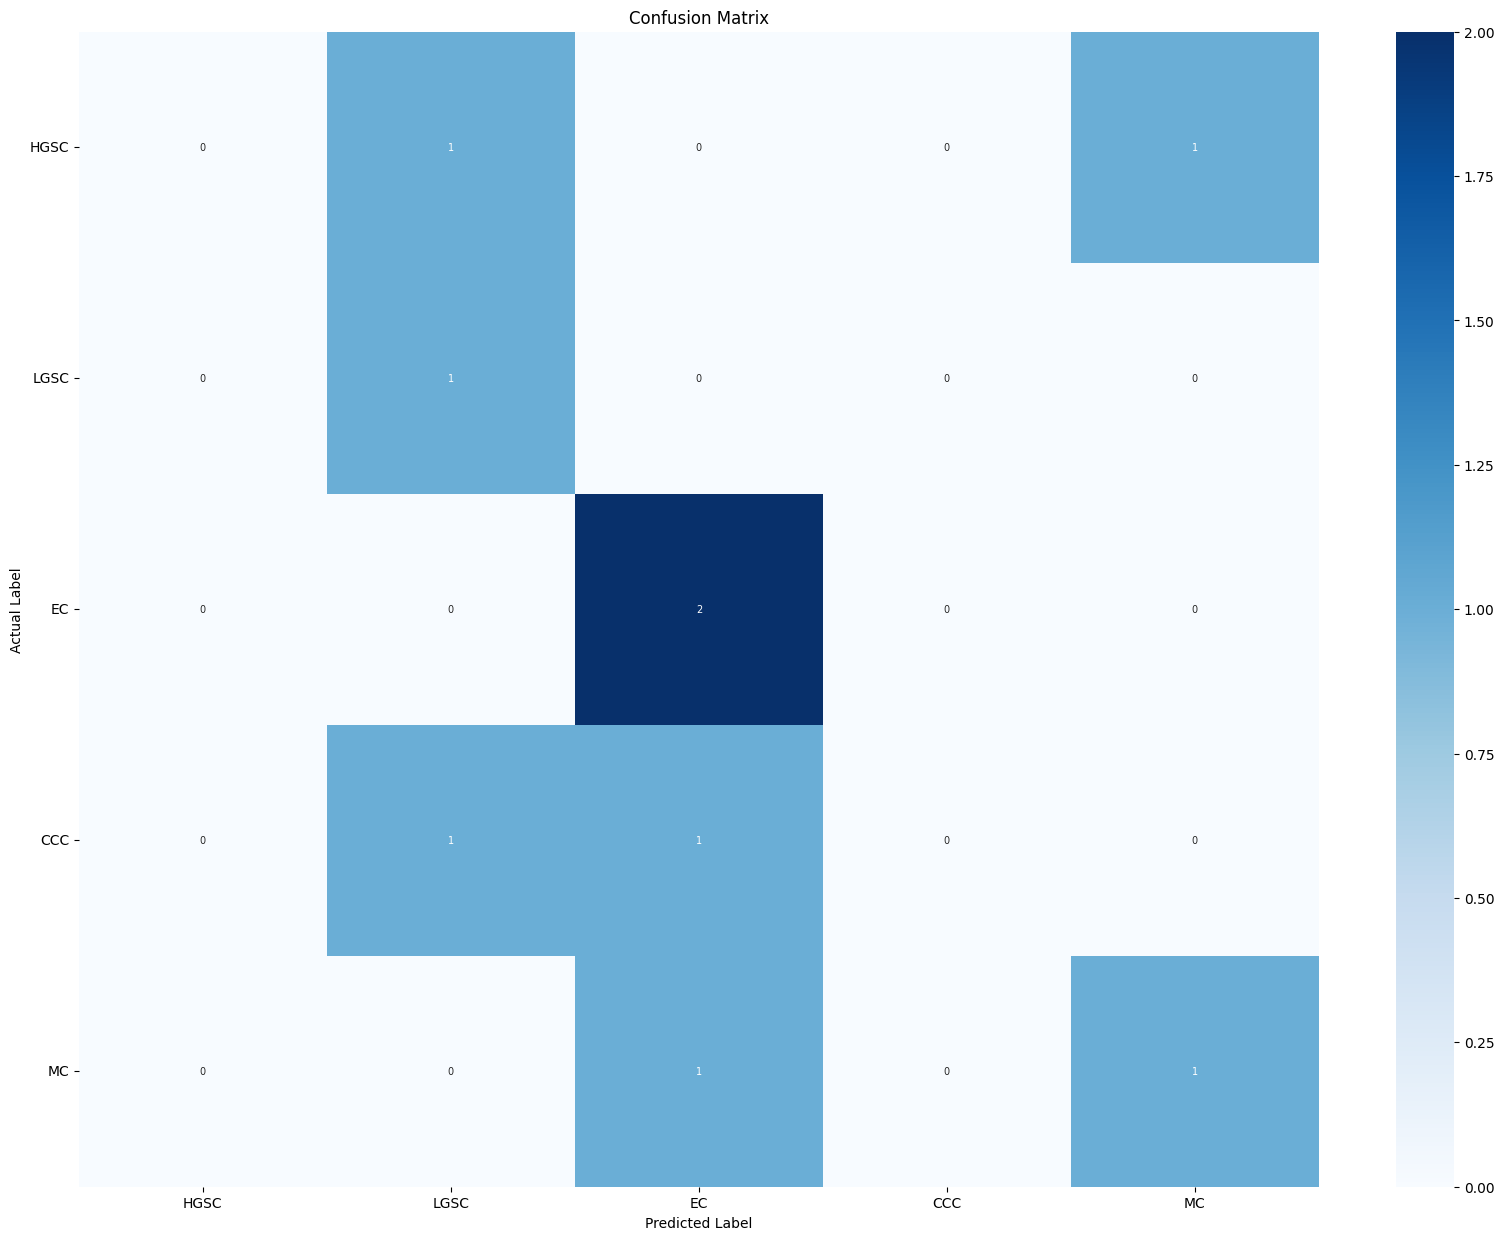

In [15]:
# Use trained SVM to classify test data
downsampled_predicted_labels = downsampled_classifier.predict(downsampled_test_data)

# Convert to subtype strings so confusion matrix labels are meaningful
downsampled_predicted_labels_strs = [convert_int_to_subtype(label).name for label in downsampled_predicted_labels]
downsampled_testing_labels_strs = [convert_int_to_subtype(label).name for label in downsampled_test_labels]

possible_labels = list(Subtype.__members__.keys())
evaluate_predictions(downsampled_testing_labels_strs, downsampled_predicted_labels_strs, possible_labels)